## QBS 108: Applied Machine Learning
---
Homework 1

Attribute Information

    0. age
    1. sex
    2. chest pain type (4 values)
    3. resting blood pressure
    4. serum cholestoral in mg/dl
    5. fasting blood sugar > 120 mg/dl
    6. resting electrocardiographic results (values 0, 1, 2)
    7. maximum heart rate achieved
    8. exercise induced angina
    9. oldpeak = ST depression induced by exercise relative to rest
    10. the slope of the peak exercise ST segment
    11. number of major vessls (0-3) colored by fluorosopy
    12. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
    13. heart disease: absence = 1, presence = 2

1. Create a Naive Bayes classifier and describe diagnostic performance using F-Score, Sensitivity, Specificity, and Accuracy on the training and validation set.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Helper functions

def rename_columns(df, new_names):
    """
    Rename columns
    
    @param df: dataframe to be renamed
    @params new_names: a list of the names for the columns
    
    Return a dataframe with the renamed columns
    """
    df.columns = new_names
    return df

def one_hot_encode(df, columns):
    """
    One hot encode specific columns
    
    @param df: The dataframe
    @param columns: a list of columns to encode
        
    Return a dataframe with one-hot encoded columns
    """
    # Iterate through the columns of interest
    for col in columns:
        # Using the get_dummies function from pandas to one-hot encode
        onehot = pd.get_dummies(df[col], prefix = col)
        # Add these one-hot encoded columns to the dataframe
        df = pd.concat([df, onehot], axis = 1)
        # Remove the original columns
        del df[col]
    return df

def columnwise_standard_normalize(vec):
    """
    Helper function to perform zero-centering and s.d. scaling
    
    @param vec: 1D array (e.g. column in a 2D dataframe)
    """
    mu = np.mean(vec)
    sd = np.std(vec)
    return (vec - mu) / sd

def preprocess(df, continuous_cols):
    """
    Apply standard normalization to continuous variables
    
    @param df: Dataframe
    @param continuous_cols: Columns that are continuous variables
    
    Returns the standrad normalized columns
    """
    for c in continuous_cols:
        df.loc[:,c] = columnwise_standard_normalize(df.loc[:,c])
    return df

def evaluate(features, true_labels, model):
    """
    Evaluate model performance
    
    @param features: The validation or test features to predict labels
    @param true_labels: The correct labels
    @param model: The model trained on the training data
        
    Displays F1-score, sensitivity, specificity, and accuracy values
    """
    predicted_labels = model.predict(features)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    
    f1 = f1_score(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    sensitivity = tp/(fp + tp)
    specificity = tn/(fn + tn)
    
    print('F1-score: {:.4f}'.format(f1))
    print('Accuracy: {:.4f}'.format(acc))
    print('Sensitivity: {:.4f}'.format(sensitivity))
    print('Specificity: {:.4f}'.format(specificity))
    
def train_evaluate_sgd(train_features, train_labels, val_features, val_labels, alpha):
    """
    Train and evaluate the L2-regularized logistic regression with SGD model
    
    @param train_features: The training features
    @param train_labels: The training labels
    @param val_features: The validation features
    @param val_labels: The validation labels
    @param alpha: A list of the regularization values
        
    Displays F1-score, sensitivity, specificity, and accuracy values
    """
    for a in alpha:
        model = SGDClassifier(loss = 'log', penalty = 'l2', alpha = a, max_iter = 1000, random_state = 0)
        model.fit(train_features, train_labels)

        # Use the evaluate function before within this function
        print('Diagnostic Performance when alpha = {}'.format(a))
        print('=====================================')
        evaluate(val_features, val_labels, model)
        print()
        
def plot_train_val_error(optimum_alpha):
    """
    Plot the training and validation error for the best lambda value

    @param optimum_alpha: The best lambda value you deemed from previous problem
    
    Displays a plot of the training and validtion error
    
    Returns the fitted model
    """
    # Fit the model on the training features and training labels
    model = SGDClassifier(loss = 'log', penalty = 'l2', alpha = optimum_alpha, random_state = 0)
    model.fit(train_data, train_labels)
    
    # Initialize empty lists to contain the train and validation error
    train_error = []
    val_error = []

    best = 1
    count = -1
    bestcount = 0
    # Loop for 1000 iterations
    for i in range(0,1000):
        count += 1 
        
        # Fit the model again based on initial coefficients from the fitted
        # model above
        model.fit(train_data, train_labels, coef_init = model.coef_)

        # Get the predicted probabilities to calculate 
        # the log loss of the training data
        predicted_train_proba = model.predict_proba(train_data)
        train_loss = log_loss(train_labels, predicted_train_proba)

        # Get the predicted probabilities to calculate the
        # log loss of the validation data
        predicted_val_proba = model.predict_proba(val_data)
        val_loss = log_loss(val_labels, predicted_val_proba)

        train_error.append(train_loss)
        val_error.append(val_loss)

        if val_loss < best:
            model_best = model
            bestcount = count
            best = val_loss
            
    x_plot = np.linspace(0,1,1001)
    plt.plot(train_error, label = 'Train loss')
    plt.plot(val_error, label = 'Validation loss')
    plt.plot((bestcount, bestcount), (0,1))
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model

def plot_confusion_matrix(true_labels, predicted_labels):
    """
    Plot a confusion matrix
    
    @param true_labels: The test data labels
    @param predicted_labels: The predicted test labels
    
    Displays a confusion matrix
    """
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, columns = np.unique(true_labels),
                        index = np.unique(true_labels))
    df_cm.index.name = 'True Labels'
    df_cm.columns.name = 'Predicted Labels'

    cm_fig = sns.heatmap(df_cm, cmap = 'Blues', 
                         annot = True, 
                         cbar = False)
    for _, spine in cm_fig.spines.items():
        spine.set_visible(True)

In [3]:
# Read in the train data
heart_train = pd.read_csv('hearttrain.csv')
heart_train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,255,71.0,0.0,2.0,160.0,302.0,0.0,0.0,162.0,0.0,0.4,1.0,2.0,3.0,1
1,204,55.0,1.0,4.0,160.0,289.0,0.0,2.0,145.0,1.0,0.8,2.0,1.0,7.0,2
2,267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
3,92,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0,1.0,7.0,2
4,149,41.0,0.0,3.0,112.0,268.0,0.0,2.0,172.0,1.0,0.0,1.0,0.0,3.0,1


In [4]:
col_names = ['age', 'sex', 'chest pain type', 'resting blood pressure', 'serum cholesterol', 
             'fasting blood sugar', 'resting electrocardiographic results', 'maximum heart rate achieved',
             'exercise induced angina', 'oldpeak', 'slope of the peak exercise ST segment', 
             'number of major vessls colored by fluorosopy', 'thal']

continuous_cols = ['age', 'chest pain type', 'resting blood pressure', 'serum cholesterol', 
                   'fasting blood sugar', 'maximum heart rate achieved',
                   'exercise induced angina', 'oldpeak', 'slope of the peak exercise ST segment', 
                   'number of major vessls colored by fluorosopy']

In [5]:
# Extract the training features of interest, in this case, columns 0 through 12
# Extract the training labels, in this case, the last column
train_features, train_labels = heart_train.loc[:,'0':'12'], heart_train['13']

In [6]:
train_features = rename_columns(train_features, col_names)
train_features.head()

,age,sex,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,thal
0,71.0,0.0,2.0,160.0,302.0,0.0,0.0,162.0,0.0,0.4,1.0,2.0,3.0
1,55.0,1.0,4.0,160.0,289.0,0.0,2.0,145.0,1.0,0.8,2.0,1.0,7.0
2,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0
3,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0,1.0,7.0
4,41.0,0.0,3.0,112.0,268.0,0.0,2.0,172.0,1.0,0.0,1.0,0.0,3.0


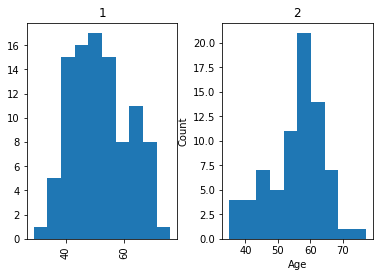

In [7]:
# EDA

# Example: age distribution by class
train_features['age'].hist(by = train_labels)
plt.xlabel("Age")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.show()

In [8]:
tt_age = stats.ttest_ind(
    train_features['age'][train_labels == 1], 
    train_features['age'][train_labels == 2]
)
print("Two-tailed t-test test-statistics %.2f" % tt_age.statistic)
print("P-value %.5f" % tt_age.pvalue)

Two-tailed t-test test-statistics -2.72
P-value 0.00723


One hot encode the nominal columns sex, resting electrocardiographic results, and thal for train, val, and test data set

In [9]:
train_onehot = one_hot_encode(train_features, ['sex', 'resting electrocardiographic results', 'thal'])
train_onehot.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,71.0,2.0,160.0,302.0,0.0,162.0,0.0,0.4,1.0,2.0,1,0,1,0,0,1,0,0
1,55.0,4.0,160.0,289.0,0.0,145.0,1.0,0.8,2.0,1.0,0,1,0,0,1,0,0,1
2,56.0,2.0,140.0,294.0,0.0,153.0,0.0,1.3,2.0,0.0,1,0,0,0,1,1,0,0
3,54.0,4.0,124.0,266.0,0.0,109.0,1.0,2.2,2.0,1.0,0,1,0,0,1,0,0,1
4,41.0,3.0,112.0,268.0,0.0,172.0,1.0,0.0,1.0,0.0,1,0,0,0,1,1,0,0


In [10]:
train_data = preprocess(train_onehot, continuous_cols)
train_data.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,1.838397,-1.260511,1.830460,0.896618,-0.45033,0.426475,-0.658281,-0.475707,-0.931059,1.379944,1,0,1,0,0,1,0,0
1,0.156459,0.844420,1.830460,0.656833,-0.45033,-0.345191,1.519109,-0.138993,0.754648,0.343479,0,1,0,0,1,0,0,1
2,0.261580,-1.260511,0.601580,0.749058,-0.45033,0.017946,-0.658281,0.281901,0.754648,-0.692985,1,0,0,0,1,1,0,0
3,0.051338,0.844420,-0.381525,0.232599,-0.45033,-1.979308,1.519109,1.039508,0.754648,0.343479,0,1,0,0,1,0,0,1
4,-1.315236,-0.208045,-1.118853,0.269489,-0.45033,0.880396,1.519109,-0.812422,-0.931059,-0.692985,1,0,0,0,1,1,0,0


In [11]:
heart_val = pd.read_csv('heartval.csv')
val_features = heart_val.loc[:, '0':'12']
val_labels = heart_val['13']

val_features = rename_columns(val_features, col_names)
val_onehot = one_hot_encode(val_features, ['sex', 'resting electrocardiographic results', 'thal'])
val_onehot.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,59.0,1.0,178.0,270.0,0.0,145.0,0.0,4.2,3.0,0.0,0,1,0,0,1,0,0,1
1,56.0,4.0,130.0,283.0,1.0,103.0,1.0,1.6,3.0,0.0,0,1,0,0,1,0,0,1
2,57.0,3.0,128.0,229.0,0.0,150.0,0.0,0.4,2.0,1.0,0,1,0,0,1,0,0,1
3,59.0,4.0,110.0,239.0,0.0,142.0,1.0,1.2,2.0,1.0,0,1,0,0,1,0,0,1
4,67.0,4.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,2.0,0,1,0,0,1,0,0,1


In [12]:
val_data = preprocess(val_onehot, continuous_cols)
val_data.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,0.337409,-2.203000,2.155885,0.603257,-0.471405,-0.099826,-0.871780,3.047577,1.994564,-0.744092,0,1,0,0,1,0,0,1
1,-0.033741,0.957826,-0.042680,0.884712,2.121320,-2.105018,1.147079,0.449642,1.994564,-0.744092,0,1,0,0,1,0,0,1
2,0.089976,-0.095783,-0.134287,-0.284407,-0.471405,0.138888,-0.871780,-0.749404,0.507093,0.425195,0,1,0,0,1,0,0,1
3,0.337409,0.957826,-0.958749,-0.067903,-0.471405,-0.243054,1.147079,0.049960,0.507093,0.425195,0,1,0,0,1,0,0,1
4,1.327142,0.957826,-0.500715,-0.284407,-0.471405,-0.863708,1.147079,1.448848,0.507093,1.594482,0,1,0,0,1,0,0,1


In [13]:
heart_test = pd.read_csv('hearttest.csv')
test_features = heart_test.loc[:, '0':'12']
test_labels = heart_test['13']

test_features = rename_columns(test_features, col_names)
test_onehot = one_hot_encode(test_features, ['sex', 'resting electrocardiographic results', 'thal'])
# Insert a column full of zeros to match the number of columns of our training and validation data
# 13 is the location of column 'resting electrocardiographic results_0.0', I placed
# 'resting electrocardiographic results_1.0' next to it
test_onehot.insert(13, 'resting electrocardiographic results_1.0', 0)
test_onehot.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,49.0,3.0,120.0,188.0,0.0,139.0,0.0,2.0,2.0,3.0,0,1,1,0,0,0,0,1
1,54.0,3.0,108.0,267.0,0.0,167.0,0.0,0.0,1.0,0.0,1,0,0,0,1,1,0,0
2,65.0,4.0,135.0,254.0,0.0,127.0,0.0,2.8,2.0,1.0,0,1,0,0,1,0,0,1
3,46.0,4.0,140.0,311.0,0.0,120.0,1.0,1.8,2.0,2.0,0,1,1,0,0,0,0,1
4,57.0,3.0,150.0,168.0,0.0,174.0,0.0,1.6,1.0,0.0,0,1,1,0,0,1,0,0


In [14]:
test_data = preprocess(test_onehot, continuous_cols)
test_data.head()

,age,chest pain type,resting blood pressure,serum cholesterol,fasting blood sugar,maximum heart rate achieved,exercise induced angina,oldpeak,slope of the peak exercise ST segment,number of major vessls colored by fluorosopy,sex_0.0,sex_1.0,resting electrocardiographic results_0.0,resting electrocardiographic results_1.0,resting electrocardiographic results_2.0,thal_3.0,thal_6.0,thal_7.0
0,-0.856557,-0.177705,-0.832802,-1.224736,-0.242536,-0.132296,-0.707107,0.708098,0.599760,2.454604,0,1,1,0,0,0,0,1
1,-0.233187,-0.177705,-1.486138,0.505878,-0.242536,0.937393,-0.707107,-1.152597,-1.019592,-0.752217,1,0,0,0,1,1,0,0
2,1.138228,0.888523,-0.016132,0.221094,-0.242536,-0.590734,-0.707107,1.452376,0.599760,0.316723,0,1,0,0,1,0,0,1
3,-1.230579,0.888523,0.256092,1.469765,-0.242536,-0.858156,1.414214,0.522028,0.599760,1.385663,0,1,1,0,0,0,0,1
4,0.140836,-0.177705,0.800538,-1.662867,-0.242536,1.204815,-0.707107,0.335959,-1.019592,-0.752217,0,1,1,0,0,1,0,0


In [15]:
# Fit the Gaussian Naive Bayes classifier onto the training data
gnb = GaussianNB()
gnb.fit(train_data, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
evaluate(val_data, val_labels, gnb)

F1-score: 0.3871
Accuracy: 0.5682
Sensitivity: 0.5135
Specificity: 0.8571


2. Starting from the MLE of Logistic Regression with regularization, derive the formula for a single stochastic gradient descent update.

Minimize log-likelihood:

$$
\begin{aligned}
ln(L) = \sum_{i}^N y_{i}ln(p(x_{i})) + (1 - y_{i})ln[1 - p(x_{i})] - \lambda ||w||_{2}^{2}
\end{aligned}
$$

where:

$$
\begin{aligned}
p(x_{i}) = \frac{e^{w'x}}{1 + e^{w'x}}
\end{aligned}
$$

for each sample $j$.

For each $w_{t}$ in $w$:
$$
\begin{aligned}
\frac{\partial ln(L)}{\partial w_{t}} ln(L) = \sum_{j}^{N}(y_{j} - p(x_{j}))x_{j} - 2\lambda w_{t}
\end{aligned}
$$

Making the gradient updates:
$$
\begin{aligned}
w_{t+1} = w_{t} + \eta[\sum_{j}^{N}(y_{j} - p(x_{j}))x_{j} - 2\lambda w_{t}]
\end{aligned}
$$

3. Train an L2-regularized logistic regression by stochastic gradient descent on the training heart dataset. Using regularization $\lambda$ = 1e-16, 0.001, 0.01, 0.1, 1. Describe best diagnostic performance using F-Score, Sensitivity, Specificity, and Accuracy and determine the optimum lambda based on the validation heart set, or 5-fold cross validation.

In [17]:
train_evaluate_sgd(train_data, train_labels, val_data, val_labels, alpha = [1e-16, 0.001, 0.01, 0.1, 1])

Diagnostic Performance when alpha = 1e-16
F1-score: 0.7500
Accuracy: 0.7273
Sensitivity: 0.7000
Specificity: 0.7500

Diagnostic Performance when alpha = 0.001
F1-score: 0.7273
Accuracy: 0.7273
Sensitivity: 0.6667
Specificity: 0.8000

Diagnostic Performance when alpha = 0.01
F1-score: 0.7826
Accuracy: 0.7727
Sensitivity: 0.7273
Specificity: 0.8182

Diagnostic Performance when alpha = 0.1
F1-score: 0.7755
Accuracy: 0.7500
Sensitivity: 0.7368
Specificity: 0.7600

Diagnostic Performance when alpha = 1
F1-score: 0.7925
Accuracy: 0.7500
Sensitivity: 0.8000
Specificity: 0.7241



The optimum $\lambda$ based on the validation set is `0.01` because it has the highest accuracy.

4. Plot training and validation error for 1000 stochastic gradient descent iterations for the best lambda.

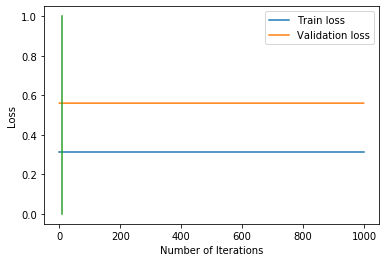

In [19]:
clf = plot_train_val_error(optimum_alpha = 0.01)

5. Return predictions on test set

In [20]:
predicted_test_labels = clf.predict(test_data)
predicted_test_labels

array([2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 2], dtype=int64)

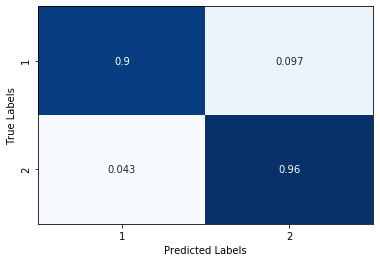

In [21]:
plot_confusion_matrix(predicted_test_labels, test_labels)

In [22]:
evaluate(test_data, test_labels, clf)

F1-score: 0.9333
Accuracy: 0.9259
Sensitivity: 0.9565
Specificity: 0.9032
